In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import time
import os
import re
import gc
import tsfresh
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import chi2
from sklearn.compose import TransformedTargetRegressor
from yellowbrick.cluster import KElbowVisualizer
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.frequent_patterns import apriori, association_rules
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from scipy import stats
from tqdm import tqdm
from hcuppy.ccs import CCSEngine
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)
np.random.seed(1234)
tf.random.set_seed(1234)

## 1. Loading Data and Feature Engineering

In [3]:
def query_db(query):    
    
    """
    Connect to SQL server
    """
    
    connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=hex6\hex6;DATABASE=AIML;Trusted_Connection=yes;')
    cur = connection.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    rows = pd.DataFrame(rows)
    
    return rows

In [4]:
def filter_data(df, columns):
    
    """
    Convert the dataframe loaded from SQL to the dataframe for Python
    """
    
    map_gender = {'Male':0, 'Female':1}
    map_race = {'White':0, 'HISpanic':1, 'Asian':2, 'Black':3, 'Native American':4, 'Other':5, 'Unknown':6}
    HCC_map = {'No':0, 'Yes':1}
    
    for i, col in enumerate(columns):
        df[col] = df[0].apply(lambda x: x[i])
    df = df.drop([0], axis=1)
    
    for col in ['Anchordate', 'DOB']:
        df[col] = pd.to_datetime(df[col])    
    
    df.insert(1, 'Year', df['Anchordate'].dt.year)
    df.insert(2, 'Month', df['Anchordate'].dt.month)
    df.insert(3, 'YOB', df['DOB'].dt.year)
    df = df.rename(columns={'Memberid':'MemberID'})    
    df['MemberGender'] = df['MemberGender'].map(map_gender)
    df['MemberRace'] = df['MemberRace'].map(map_race)
    
    for col in columns:
        if col.__contains__('HCC'):
            df[col] = df[col].map(HCC_map)
    
    return df

In [5]:
def shift_additional_feature(data, additional_features, shift_windows = [1]):    
    
    """
    Shift features to the future
    """
    
    for i in shift_windows:
        for feature in tqdm(additional_features):
            data[feature] = data.groupby(['MemberID'], as_index=False)[feature].transform(lambda x: x.shift(i))
        
    return data

In [6]:
def select_HCC_features(df, num_HCC_selected):
    
    """
    Select top HCC having highest correlation with high-cost label
    """
    
    HCC_list = []

    for col in df_for_train1.columns:
        if col.__contains__('HCC'):
            HCC_list.append(col)
    
    temp = df[HCC_list]
    temp['High cost label'] = df['High cost label']
    
    corr = temp.corr()
    corr = corr.reset_index(drop=False)
    corr = corr[['index', 'High cost label']]    
    corr = corr.reset_index(drop=True)    
    corr.columns = ['HCC', 'Corr_with_High_cost_label']
    corr = corr.sort_values('Corr_with_High_cost_label', ascending=False)
    corr['1_Count'] = np.nan

    for i in range(corr.shape[0]):
        corr.iloc[i, corr.columns.get_loc('1_Count')] = Counter(temp[corr.iloc[i]['HCC']])[1]
    
    corr = corr.iloc[1:]
    top_HCC_list = corr.dropna().iloc[:num_HCC_selected]['HCC']
    bottom_HCC_list = corr.dropna().iloc[-num_HCC_selected:]['HCC']
    selected_HCC = [*top_HCC_list, *bottom_HCC_list]
    drop_HCC = set(HCC_list) - set(selected_HCC)
        
    return corr, selected_HCC, drop_HCC

In [7]:
def create_tsf(data, column):
    
    """
    Make time series features
    """
    
    shift_windows = [1]
    shift_windows1 = [1]    
    rolling_windows = [2,3,4,5]    
    EWF_windows = [2,3,4,5]    
        
    for i in shift_windows1:
        data[column+'_lag_'+str(i)] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i))            
             
    for i in shift_windows:
        for j in tqdm(rolling_windows):
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_mean'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).mean())            
#             data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_std'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).std())
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_sum'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).sum())   
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_median'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).median()) 
#             data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_var'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).var())   
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_max'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).max())   
            data[column+'_shift_'+str(i)+'_roll_'+str(j)+'_min'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).rolling(window=j, min_periods=1).min())   
            
    for i in shift_windows:
        for j in tqdm(EWF_windows):
            data[column+'_shift_'+str(i)+'_ewf_'+str(j)+'_mean'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).ewm(span=j, min_periods=1).mean())            
#             data[column+'_shift_'+str(i)+'_ewf_'+str(j)+'_std'] = data.groupby(['MemberID'], as_index=False)[column].transform(lambda x: x.shift(i).ewm(span=j, min_periods=1).std())            
    
    return data

In [8]:
query_for_train = """
        SELECT a.* ,b.QRTR
        FROM [AIML].[dbo].[Expenditure_Prediction]a
        LEFT JOIN [AIML].[dbo].[BI_DT_DIM]b
        ON a.Anchordate = b.CalDT
        WHERE AnchorDate <= '2019-11-30'
        AND [MedicareStatus] = 'AgedNonDual'
        ORDER BY Memberid, Anchordate
        """

query_for_test1 = """
        SELECT a.* ,b.QRTR
        FROM [AIML].[dbo].[Expenditure_Prediction]a
        LEFT JOIN [AIML].[dbo].[BI_DT_DIM]b
        ON a.Anchordate = b.CalDT
        WHERE AnchorDate IN ('2019-12-31')   
        AND [MedicareStatus] = 'AgedNonDual'
        ORDER BY Memberid, Anchordate
        """

In [9]:
raw_train = query_db(query_for_train)
raw_test1 = query_db(query_for_test1)

In [10]:
columns = ['Memberid', 'Anchordate', 'First CLaim Date',
       'First Claim Date In 12 Months Period', 'DOB', 'AGE', 'MemberGender',
       'MemberRace', 'MedicareStatus', 'ZipCode', 'Expenditure',
       'Monthly Expenditure', 'Threshold Expenditure', 'Total Expenditure',
       'Threshold Expenditure IND', 'Total Claims', 'PART A CLAIMS',
       'PART B CLAIMS', 'PART D CLAIMS', 'ED_Vists',
          'Admissions', 'PCP_Visits', 'RISK SCORE', 'SNF COUNT', 'HOSPITAL LOS',
       'HOSPICE IND', 'HCC_1', 'HCC_2', 'HCC_6', 'HCC_8', 'HCC_9', 'HCC_10',
       'HCC_11', 'HCC_12', 'HCC_17', 'HCC_18', 'HCC_19', 'HCC_21', 'HCC_22',
       'HCC_23', 'HCC_27', 'HCC_28', 'HCC_29', 'HCC_33', 'HCC_34', 'HCC_35', 'HCC_39',
       'HCC_40', 'HCC_46', 'HCC_47', 'HCC_48', 'HCC_51', 'HCC_52', 'HCC_55',
       'HCC_56', 'HCC_57', 'HCC_58', 'HCC_59', 'HCC_60', 'HCC_70',
          'HCC_71', 'HCC_72', 'HCC_73', 'HCC_74', 'HCC_75', 'HCC_76', 'HCC_77',
       'HCC_78', 'HCC_79', 'HCC_80', 'HCC_82', 'HCC_83', 'HCC_84', 'HCC_85',
       'HCC_86', 'HCC_87', 'HCC_88', 'HCC_96', 'HCC_99', 'HCC_100',
          'HCC_103', 'HCC_104', 'HCC_106', 'HCC_107', 'HCC_108', 'HCC_110',
       'HCC_111', 'HCC_112', 'HCC_114', 'HCC_115', 'HCC_122', 'HCC_124',
       'HCC_134', 'HCC_135', 'HCC_136', 'HCC_137', 'HCC_138', 'HCC_157',
       'HCC_158', 'HCC_159', 'HCC_161', 'HCC_162', 'HCC_166', 'HCC_167',
       'HCC_169', 'HCC_170', 'HCC_173', 'HCC_176', 'QRTR']
df_for_train = filter_data(raw_train, columns)
df_for_test1 = filter_data(raw_test1, columns)
test_columns = df_for_test1.drop(['MemberID', 'Year', 'Month'], axis=1).columns

for col in test_columns:
    df_for_test1[col] = df_for_test1[col].apply(lambda x: np.nan)

In [11]:
"""Make high-cost label"""

df_for_train[['Monthly Expenditure', 'Threshold Expenditure']] = df_for_train[['Monthly Expenditure', 'Threshold Expenditure']].astype(float)
df_for_train['Threshold Expenditure'] = df_for_train['Threshold Expenditure']/12
df_for_train = df_for_train.fillna(0)
df_for_train['Monthly Expenditure'] = df_for_train[['Monthly Expenditure', 'Threshold Expenditure']].apply(lambda x: x['Monthly Expenditure'] if x['Monthly Expenditure']<x['Threshold Expenditure']
                                                                                                          else x['Threshold Expenditure'], axis=1)
quarterly_exp_df = df_for_train.groupby(['MemberID', 'QRTR'], as_index=False)['Monthly Expenditure'].sum()
quarterly_exp_df = quarterly_exp_df.rename(columns={'Monthly Expenditure':'Quarterly Expenditure'})
df_for_train = df_for_train.merge(quarterly_exp_df, how='left', left_on=['MemberID', 'QRTR'], right_on=['MemberID', 'QRTR'])
df_for_train = df_for_train[(df_for_train['Month']==3)|(df_for_train['Month']==6)|(df_for_train['Month']==9)|(df_for_train['Month']==12)]

In [12]:
"""Make high-cost label"""

drop_columns = ['Anchordate', 'First CLaim Date', 'DOB', 'AGE',
                'First Claim Date In 12 Months Period',
                'Expenditure', 'Monthly Expenditure', 'Threshold Expenditure', 'Total Expenditure',
               'Threshold Expenditure IND', 'HOSPICE IND', 'QRTR']
df_for_train = df_for_train.drop(drop_columns, axis=1)
df_for_test1 = df_for_test1.drop(drop_columns, axis=1)
label_encode = LabelEncoder()
df_for_train['ZipCode'] = label_encode.fit_transform(df_for_train['ZipCode'])
df_for_train['MedicareStatus'] = label_encode.fit_transform(df_for_train['MedicareStatus'])

In [13]:
"""Make high-cost label"""

df_for_train['Previous Quarterly Expenditure'] = df_for_train.groupby(['MemberID'], as_index=False)['Quarterly Expenditure'].transform(lambda x: x.shift(1))
df_for_train['Exp_difference'] = df_for_train['Quarterly Expenditure'] - df_for_train['Previous Quarterly Expenditure']
temp = df_for_train.groupby(['Year', 'Month', 'MedicareStatus'], as_index=False)['Quarterly Expenditure'].mean()
temp = temp.rename(columns={'Quarterly Expenditure':'Avg_exp_per_group'})
df_for_train = df_for_train.merge(temp, how='left', left_on=['Year', 'Month', 'MedicareStatus'], right_on=['Year', 'Month', 'MedicareStatus'])
df_for_train['High cost label'] = df_for_train[['Quarterly Expenditure', 'Exp_difference',
                                                'Avg_exp_per_group']].apply(lambda x: 1 if 
                                                                            x['Quarterly Expenditure']>x['Avg_exp_per_group'] 
                                                                            and x['Exp_difference']>=2500 else 0, axis=1)

In [14]:
df_for_train[['Exp_difference']] = df_for_train[['Exp_difference']].fillna(0)
df_for_train['Exp_factor'] = df_for_train['Quarterly Expenditure']/df_for_train['Avg_exp_per_group']

In [15]:
additional_features = df_for_train.drop(['MemberID', 'Year', 'Month',
                                        'Previous Quarterly Expenditure', 'RISK SCORE',
                                         'Total Claims',
#                                          'PART A CLAIMS',
#                                         'PART B CLAIMS',
                                         'Avg_exp_per_group', 'High cost label'], axis=1).columns
df_for_train1 = df_for_train.copy()
df_for_train1 = shift_additional_feature(df_for_train1, additional_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [05:04<00:00,  3.10s/it]


In [16]:
df_for_train1 = create_tsf(df_for_train1, 'RISK SCORE')
df_for_train1 = create_tsf(df_for_train1, 'Total Claims')
# df_for_train1 = create_tsf(df_for_train1, 'PART A CLAIMS')
# df_for_train1 = create_tsf(df_for_train1, 'PART B CLAIMS')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.33s/it]


In [17]:
df_for_train1 = df_for_train1.drop(['Previous Quarterly Expenditure', 'RISK SCORE',
                                    'Total Claims',
#                                     'PART A CLAIMS',
#                                        'PART B CLAIMS' ,
                                    'Avg_exp_per_group'], axis=1)
df_for_train1 = df_for_train1.dropna()

In [18]:
df_for_test1['Quarterly Expenditure'] = np.nan

In [19]:
corr, selected_HCC, drop_HCC = select_HCC_features(df_for_train1, num_HCC_selected=10)

In [20]:
df_for_train2 = df_for_train1.copy()
df_for_train2 = df_for_train2.drop(drop_HCC, axis=1)

In [21]:
df_for_train2

,MemberID,Year,Month,YOB,MemberGender,MemberRace,MedicareStatus,ZipCode,PART A CLAIMS,PART B CLAIMS,PART D CLAIMS,ED_Vists,Admissions,PCP_Visits,SNF COUNT,HOSPITAL LOS,HCC_1,HCC_2,HCC_8,HCC_18,HCC_19,HCC_29,HCC_34,HCC_35,HCC_52,HCC_76,HCC_77,HCC_83,HCC_85,HCC_96,HCC_108,HCC_110,HCC_111,HCC_135,HCC_161,HCC_166,Quarterly Expenditure,Exp_difference,High cost label,Exp_factor,RISK SCORE_lag_1,RISK SCORE_shift_1_roll_2_mean,RISK SCORE_shift_1_roll_2_sum,RISK SCORE_shift_1_roll_2_median,RISK SCORE_shift_1_roll_2_max,RISK SCORE_shift_1_roll_2_min,RISK SCORE_shift_1_roll_3_mean,RISK SCORE_shift_1_roll_3_sum,RISK SCORE_shift_1_roll_3_median,RISK SCORE_shift_1_roll_3_max,RISK SCORE_shift_1_roll_3_min,RISK SCORE_shift_1_roll_4_mean,RISK SCORE_shift_1_roll_4_sum,RISK SCORE_shift_1_roll_4_median,RISK SCORE_shift_1_roll_4_max,RISK SCORE_shift_1_roll_4_min,RISK SCORE_shift_1_roll_5_mean,RISK SCORE_shift_1_roll_5_sum,RISK SCORE_shift_1_roll_5_median,RISK SCORE_shift_1_roll_5_max,RISK SCORE_shift_1_roll_5_min,RISK SCORE_shift_1_ewf_2_mean,RISK SCORE_shift_1_ewf_3_mean,RISK SCORE_shift_1_ewf_4_mean,RISK SCORE_shift_1_ewf_5_mean,Total Claims_lag_1,Total Claims_shift_1_roll_2_mean,Total Claims_shift_1_roll_2_sum,Total Claims_shift_1_roll_2_median,Total Claims_shift_1_roll_2_max,Total Claims_shift_1_roll_2_min,Total Claims_shift_1_roll_3_mean,Total Claims_shift_1_roll_3_sum,Total Claims_shift_1_roll_3_median,Total Claims_shift_1_roll_3_max,Total Claims_shift_1_roll_3_min,Total Claims_shift_1_roll_4_mean,Total Claims_shift_1_roll_4_sum,Total Claims_shift_1_roll_4_median,Total Claims_shift_1_roll_4_max,Total Claims_shift_1_roll_4_min,Total Claims_shift_1_roll_5_mean,Total Claims_shift_1_roll_5_sum,Total Claims_shift_1_roll_5_median,Total Claims_shift_1_roll_5_max,Total Claims_shift_1_roll_5_min,Total Claims_shift_1_ewf_2_mean,Total Claims_shift_1_ewf_3_mean,Total Claims_shift_1_ewf_4_mean,Total Claims_shift_1_ewf_5_mean
1,1A00M09YA30,2018,6,1949.000,0.000,0.000,0.000,501.000,0.000,7.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,445.550,0.000,0,0.240,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,0.275,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000
2,1A00M09YA30,2018,9,1949.000,0.000,0.000,0.000,501.000,0.000,6.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-445.550,0,0.000,0.275,0.275,0.550,0.275,0.275,0.275,0.275,0.550,0.275,0.275,0.275,0.275,0.550,0.275,0.275,0.275,0.275,0.550,0.275,0.275,0.275,0.275,0.275,0.275,0.275,6.000,6.500,13.000,6.500,7.000,6.000,6.500,13.000,6.500,7.000,6.000,6.500,13.000,6.500,7.000,6.000,6.500,13.000,6.500,7.000,6.000,6.250,6.333,6.375,6.400
3,1A00M09YA30,2018,12,1949.000,0.000,0.000,0.000,501.000,0.000,12.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,730.920,730.920,0,0.351,0.370,0.322,0.645,0.322,0.370,0.275,0.307,0.920,0.275,0.370,0.275,0.307,0.920,0.275,0.370,0.275,0.307,0.920,0.275,0.370,0.275,0.341,0.329,0.323,0.320,12.000,9.000,18.000,9.000,12.000,6.000,8.333,25.000,7.000,12.000,6.000,8.333,25.000,7.000,12.000,6.000,8.333,25.000,7.000,12.000,6.000,10.231,9.571,9.245,9.053
4,1A00M09YA30,2019,3,1949.000,0.000,0.000,0.000,501.000,0.000,14.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,161.990,-568.930,0,0.068,0.370,0.370,0.740,0.370,0.370,0.370,0.338,1.015,0.370,0.370,0.275,0.322,1.290,0.322,0.370,0.275,0.322,1.290,0.322,0.370,0.275,0.360,0.351,0.345,0.341,14.000,13.00

In [22]:
# scores, pvalues = chi2(df_for_train2.drop(['MemberID','High cost label'], axis=1), df_for_train2['High cost label'])
# pvalues=["{0:.7f}".format(x)for x in pvalues]
# chi2_distribution_df = pd.DataFrame({'Features':df_for_train2.drop(['MemberID','High cost label'], axis=1).columns,'Chi2_score':scores, 'P_values':pvalues})
# chi2_distribution_df = chi2_distribution_df.sort_values('Chi2_score', ascending=False)

In [23]:
# pd.set_option('display.max_rows', chi2_distribution_df.shape[0]+1)

In [24]:
# chi2_distribution_df

In [25]:
# pd.reset_option('max_rows')

## 2. Time Series Analysis Model

In [26]:
def make_train_validation_set(df, Year_for_val, Month_for_val):
    
    """
    Split dataset to train set and test set
    """
    
    df = df.reset_index()
    index_val = df[(df['Year']==Year_for_val)&(df['Month']==Month_for_val)]['index']
    df_train = df[~df['index'].isin(index_val)]
    df_val = df[(df['Year']==Year_for_val)&(df['Month']==Month_for_val)]
    X_train = df_train.drop(['index','MemberID','High cost label'], axis=1)
    y_train = df_train['High cost label']
    X_val = df_val.drop(['index','MemberID','High cost label'], axis=1)
    y_val = df_val['High cost label']
    
    return X_train, y_train, X_val, y_val

In [27]:
X_train, y_train, X_val, y_val = make_train_validation_set(df_for_train2, Year_for_val=2018, Month_for_val=6)

In [28]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

In [29]:
type_count = Counter(df_for_train2['High cost label'])
class_weights = len(df_for_train2['High cost label'])/pd.DataFrame(type_count.values())/len(type_count)
classes = list(type_count.keys())
class_weights_map = {}

for cls, weight in zip(type_count.keys(), class_weights[0]):
    class_weights_map[cls] = weight
    
class_weights_map

{0: 0.5519017712229201, 1: 5.316791298436438}

In [30]:
# class_weights_map = {0: 0.8, 1: 4}
class_weights_map = {0: 0.7, 1: 3}

In [31]:
def build_model(model_name, lgb_params, LSTM_input_shape=None): # LSTM_input_shape=[1, X_train.shape[1]]
    
    """
    Make LGBM or LSTM model
    """
    
    if model_name == 'LGBM':        
        LGBM_model = LGBMClassifier(**lgb_params)
        return LGBM_model
    
    elif model_name == 'LSTM':
        LSTM_model = keras.Sequential()
        LSTM_model.add(keras.layers.LSTM(
                  units=100,          
                  input_shape=LSTM_input_shape,
        #     kernel_initializer='he_normal',
        #     use_bias=False,    
                  recurrent_dropout=0.5,
                  return_sequences=True,
        #     unroll=True
              )    
        )
        LSTM_model.add(keras.layers.LSTM(
                  units=100,                    
        #     kernel_initializer='he_normal',
        #     use_bias=False,              
                  return_sequences=True,
        #     recurrent_dropout=0.2,
        #     unroll=True
              )    
        )
        LSTM_model.add(keras.layers.LSTM(
                  units=100,                    
        #     kernel_initializer='he_normal',
        #     use_bias=False,              
                  return_sequences=True,
        #     recurrent_dropout=0.2,
        #     unroll=True
              )    
        )
        LSTM_model.add(keras.layers.Dense(units=128, activation='relu'))
        LSTM_model.add(keras.layers.Dense(units=2, activation='sigmoid'))

        # opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")

        LSTM_model.compile(
          loss='categorical_crossentropy',  
          optimizer='adam',
          metrics=['acc']
        )
        return LSTM_model

In [32]:
def create_dataset_sequence(X, y, time_steps=1, step=1):
    
    """
    create sequence input for LSTM model
    """
    
    Xs, ys = [], []
    for i in range(0, len(X), step):
#         v = X.iloc[i:(i + time_steps)].values
        v = X[i:(i + time_steps),:]
        labels = y[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), ys

In [33]:
def decay_schedule(epoch, lr):
    
    """
    reduce learning rate during training for LSTM model
    """
    
    if (epoch % 5 == 0) and (epoch != 0):
        lr = lr * 0.2
        
    return lr

In [34]:
def training(df, model, X_train, y_train, X_val, y_val, batch_size=16):
    
    """
    function to train the model
    """
    
    if model == LGBM_model:
        LGBM_model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_val,y_val)], 
       verbose=2, early_stopping_rounds=10, 
                       sample_weight = y_train.map(class_weights_map)
                      )
        return LGBM_model
    
    elif model == LSTM_model:
        X_train1  = scaler.fit_transform(X_train)        
        X_val1  = scaler.transform(X_val)
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train = np.array(y_train).reshape(-1,1)
        y_val = np.array(y_val).reshape(-1,1)
        enc = enc.fit(y_train)
        y_train = enc.transform(y_train)
        y_val = enc.transform(y_val)
        X_train1, y_train = create_dataset_sequence(X_train1, y_train)
        X_val1, y_val = create_dataset_sequence(X_val1, y_val)        
        
        lr_scheduler = LearningRateScheduler(decay_schedule)
        callbacks = [EarlyStopping(monitor='val_loss', patience=4),
                     lr_scheduler,
        #              ModelCheckpoint(filepath='F:/Chung/ML for Netrin data/LSTM_model', monitor='val_loss', save_best_only=True)
                    ]        

        history = LSTM_model.fit(
            X_train1, y_train,
            epochs=100,
            callbacks=callbacks,
            batch_size=batch_size,    
            shuffle=False,
            validation_data=(X_val1, y_val)
        )        
        
        return LSTM_model

In [35]:
def LGBM_feature_importance(feature_names, LGBM_model):
    
    """
    Generate the feature importance for LGBM model
    """
    
    fe_imp_score = sorted(zip(LGBM_model.booster_.feature_importance(importance_type='gain'), feature_names), reverse=True)
    fe_imp_df = pd.DataFrame({'model_result': fe_imp_score})
    fe_imp_df['score'] = fe_imp_df['model_result'].apply(lambda x: x[0])
    fe_imp_df['feature'] = fe_imp_df['model_result'].apply(lambda x: x[1])
    
    data = fe_imp_df['score']
    labels = fe_imp_df['feature']
    colors = sns.color_palette('pastel')[0:3]
    plt.figure(1 , figsize = (8 , 8))
    plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
    plt.show()
    
    return fe_imp_score

**LGBM Model**

In [37]:
lgb_params = {'max_depth':2,
         'learning_rate':0.001,
         'num_leaves':4,
         'reg_alpha':0,
         'reg_lambda':0,
         'colsample_bytree':0.5,
         'random_state':111,
         'subsample' :1,
         'n_estimators':5000
        }

In [38]:
LGBM_model = build_model('LGBM', lgb_params)

In [39]:
LGBM_model = training(df_for_train1, LGBM_model, X_train, y_train, X_val, y_val)

[2]	training's binary_logloss: 0.616327	valid_1's binary_logloss: 0.444756
[4]	training's binary_logloss: 0.61616	valid_1's binary_logloss: 0.444621
[6]	training's binary_logloss: 0.615991	valid_1's binary_logloss: 0.444485
[8]	training's binary_logloss: 0.615824	valid_1's binary_logloss: 0.44436
[10]	training's binary_logloss: 0.615656	valid_1's binary_logloss: 0.444224
[12]	training's binary_logloss: 0.615495	valid_1's binary_logloss: 0.444092
[14]	training's binary_logloss: 0.615332	valid_1's binary_logloss: 0.443966
[16]	training's binary_logloss: 0.615173	valid_1's binary_logloss: 0.443811
[18]	training's binary_logloss: 0.615009	valid_1's binary_logloss: 0.443666
[20]	training's binary_logloss: 0.614847	valid_1's binary_logloss: 0.443523
[22]	training's binary_logloss: 0.614686	valid_1's binary_logloss: 0.443406
[24]	training's binary_logloss: 0.614524	valid_1's binary_logloss: 0.443285
[26]	training's binary_logloss: 0.614361	valid_1's binary_logloss: 0.443152
[28]	training's bi

[400]	training's binary_logloss: 0.592351	valid_1's binary_logloss: 0.423725
[402]	training's binary_logloss: 0.592265	valid_1's binary_logloss: 0.423645
[404]	training's binary_logloss: 0.59218	valid_1's binary_logloss: 0.423566
[406]	training's binary_logloss: 0.592095	valid_1's binary_logloss: 0.423504
[408]	training's binary_logloss: 0.592011	valid_1's binary_logloss: 0.423434
[410]	training's binary_logloss: 0.591927	valid_1's binary_logloss: 0.423336
[412]	training's binary_logloss: 0.591842	valid_1's binary_logloss: 0.423264
[414]	training's binary_logloss: 0.591759	valid_1's binary_logloss: 0.423173
[416]	training's binary_logloss: 0.591675	valid_1's binary_logloss: 0.423086
[418]	training's binary_logloss: 0.591592	valid_1's binary_logloss: 0.422974
[420]	training's binary_logloss: 0.591509	valid_1's binary_logloss: 0.422893
[422]	training's binary_logloss: 0.591425	valid_1's binary_logloss: 0.422822
[424]	training's binary_logloss: 0.591343	valid_1's binary_logloss: 0.422732


[826]	training's binary_logloss: 0.578891	valid_1's binary_logloss: 0.410009
[828]	training's binary_logloss: 0.578845	valid_1's binary_logloss: 0.409964
[830]	training's binary_logloss: 0.578799	valid_1's binary_logloss: 0.409925
[832]	training's binary_logloss: 0.578754	valid_1's binary_logloss: 0.409848
[834]	training's binary_logloss: 0.578709	valid_1's binary_logloss: 0.409787
[836]	training's binary_logloss: 0.578662	valid_1's binary_logloss: 0.409741
[838]	training's binary_logloss: 0.578616	valid_1's binary_logloss: 0.409687
[840]	training's binary_logloss: 0.578571	valid_1's binary_logloss: 0.409618
[842]	training's binary_logloss: 0.578526	valid_1's binary_logloss: 0.409581
[844]	training's binary_logloss: 0.578479	valid_1's binary_logloss: 0.409548
[846]	training's binary_logloss: 0.578432	valid_1's binary_logloss: 0.409508
[848]	training's binary_logloss: 0.578388	valid_1's binary_logloss: 0.409474
[850]	training's binary_logloss: 0.578341	valid_1's binary_logloss: 0.409442

[1230]	training's binary_logloss: 0.571509	valid_1's binary_logloss: 0.400816
[1232]	training's binary_logloss: 0.571476	valid_1's binary_logloss: 0.40079
[1234]	training's binary_logloss: 0.571447	valid_1's binary_logloss: 0.400761
[1236]	training's binary_logloss: 0.571419	valid_1's binary_logloss: 0.400729
[1238]	training's binary_logloss: 0.571392	valid_1's binary_logloss: 0.400707
[1240]	training's binary_logloss: 0.571361	valid_1's binary_logloss: 0.400644
[1242]	training's binary_logloss: 0.57133	valid_1's binary_logloss: 0.400621
[1244]	training's binary_logloss: 0.571302	valid_1's binary_logloss: 0.40058
[1246]	training's binary_logloss: 0.571276	valid_1's binary_logloss: 0.400531
[1248]	training's binary_logloss: 0.571246	valid_1's binary_logloss: 0.400498
[1250]	training's binary_logloss: 0.571217	valid_1's binary_logloss: 0.400473
[1252]	training's binary_logloss: 0.571186	valid_1's binary_logloss: 0.400448
[1254]	training's binary_logloss: 0.571158	valid_1's binary_logloss

[1656]	training's binary_logloss: 0.566461	valid_1's binary_logloss: 0.395451
[1658]	training's binary_logloss: 0.566444	valid_1's binary_logloss: 0.395424
[1660]	training's binary_logloss: 0.566426	valid_1's binary_logloss: 0.395418
[1662]	training's binary_logloss: 0.566406	valid_1's binary_logloss: 0.395404
[1664]	training's binary_logloss: 0.566386	valid_1's binary_logloss: 0.395387
[1666]	training's binary_logloss: 0.566367	valid_1's binary_logloss: 0.395369
[1668]	training's binary_logloss: 0.566348	valid_1's binary_logloss: 0.395352
[1670]	training's binary_logloss: 0.56633	valid_1's binary_logloss: 0.395333
[1672]	training's binary_logloss: 0.566311	valid_1's binary_logloss: 0.395318
[1674]	training's binary_logloss: 0.56629	valid_1's binary_logloss: 0.395303
[1676]	training's binary_logloss: 0.566271	valid_1's binary_logloss: 0.395282
[1678]	training's binary_logloss: 0.566253	valid_1's binary_logloss: 0.395263
[1680]	training's binary_logloss: 0.566233	valid_1's binary_loglos

[2084]	training's binary_logloss: 0.56304	valid_1's binary_logloss: 0.392334
[2086]	training's binary_logloss: 0.563028	valid_1's binary_logloss: 0.392327
[2088]	training's binary_logloss: 0.563014	valid_1's binary_logloss: 0.392292
[2090]	training's binary_logloss: 0.563001	valid_1's binary_logloss: 0.392281
[2092]	training's binary_logloss: 0.562989	valid_1's binary_logloss: 0.392275
[2094]	training's binary_logloss: 0.562976	valid_1's binary_logloss: 0.392257
[2096]	training's binary_logloss: 0.562963	valid_1's binary_logloss: 0.392247
[2098]	training's binary_logloss: 0.56295	valid_1's binary_logloss: 0.392243
[2100]	training's binary_logloss: 0.562936	valid_1's binary_logloss: 0.392235
[2102]	training's binary_logloss: 0.562924	valid_1's binary_logloss: 0.39221
[2104]	training's binary_logloss: 0.56291	valid_1's binary_logloss: 0.392189
[2106]	training's binary_logloss: 0.562899	valid_1's binary_logloss: 0.392177
[2108]	training's binary_logloss: 0.562885	valid_1's binary_logloss:

[2524]	training's binary_logloss: 0.560461	valid_1's binary_logloss: 0.389517
[2526]	training's binary_logloss: 0.56045	valid_1's binary_logloss: 0.389503
[2528]	training's binary_logloss: 0.56044	valid_1's binary_logloss: 0.389494
[2530]	training's binary_logloss: 0.56043	valid_1's binary_logloss: 0.389485
[2532]	training's binary_logloss: 0.560419	valid_1's binary_logloss: 0.389472
[2534]	training's binary_logloss: 0.560409	valid_1's binary_logloss: 0.389457
[2536]	training's binary_logloss: 0.5604	valid_1's binary_logloss: 0.389447
[2538]	training's binary_logloss: 0.56039	valid_1's binary_logloss: 0.389432
[2540]	training's binary_logloss: 0.56038	valid_1's binary_logloss: 0.389407
[2542]	training's binary_logloss: 0.560371	valid_1's binary_logloss: 0.389401
[2544]	training's binary_logloss: 0.56036	valid_1's binary_logloss: 0.389382
[2546]	training's binary_logloss: 0.56035	valid_1's binary_logloss: 0.389378
[2548]	training's binary_logloss: 0.560341	valid_1's binary_logloss: 0.38

[2744]	training's binary_logloss: 0.559407	valid_1's binary_logloss: 0.388339
[2746]	training's binary_logloss: 0.559398	valid_1's binary_logloss: 0.388335
[2748]	training's binary_logloss: 0.559389	valid_1's binary_logloss: 0.388323
[2750]	training's binary_logloss: 0.55938	valid_1's binary_logloss: 0.388308
[2752]	training's binary_logloss: 0.559371	valid_1's binary_logloss: 0.388305
[2754]	training's binary_logloss: 0.559361	valid_1's binary_logloss: 0.388301
[2756]	training's binary_logloss: 0.559352	valid_1's binary_logloss: 0.388294
[2758]	training's binary_logloss: 0.559344	valid_1's binary_logloss: 0.388285
[2760]	training's binary_logloss: 0.559335	valid_1's binary_logloss: 0.38827
[2762]	training's binary_logloss: 0.559327	valid_1's binary_logloss: 0.388258
[2764]	training's binary_logloss: 0.559317	valid_1's binary_logloss: 0.388252
[2766]	training's binary_logloss: 0.559308	valid_1's binary_logloss: 0.388241
[2768]	training's binary_logloss: 0.559299	valid_1's binary_loglos

[3178]	training's binary_logloss: 0.557668	valid_1's binary_logloss: 0.38678
[3180]	training's binary_logloss: 0.557662	valid_1's binary_logloss: 0.38677
[3182]	training's binary_logloss: 0.557655	valid_1's binary_logloss: 0.386761
[3184]	training's binary_logloss: 0.557648	valid_1's binary_logloss: 0.38676
[3186]	training's binary_logloss: 0.557642	valid_1's binary_logloss: 0.386763
[3188]	training's binary_logloss: 0.557635	valid_1's binary_logloss: 0.386764
[3190]	training's binary_logloss: 0.557629	valid_1's binary_logloss: 0.386753
[3192]	training's binary_logloss: 0.557622	valid_1's binary_logloss: 0.386752
[3194]	training's binary_logloss: 0.557615	valid_1's binary_logloss: 0.386746
[3196]	training's binary_logloss: 0.557609	valid_1's binary_logloss: 0.386742
[3198]	training's binary_logloss: 0.557602	valid_1's binary_logloss: 0.386732
[3200]	training's binary_logloss: 0.557596	valid_1's binary_logloss: 0.386746
[3202]	training's binary_logloss: 0.55759	valid_1's binary_logloss:

In [40]:
val_predictions = LGBM_model.predict(X_val)
compare = pd.DataFrame({'predict': val_predictions, 'True_value': y_val})
confusion_matrix = pd.crosstab(compare['True_value'], compare['predict'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,4616,96
1,452,50


In [41]:
50/96

0.5208333333333334

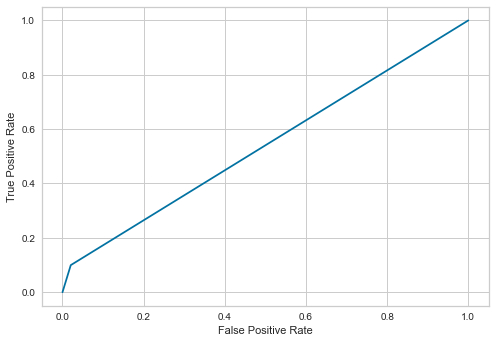

In [44]:
fpr, tpr, _ = metrics.roc_curve(compare['True_value'], compare['predict'])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
accuracy_score(val_predictions, y_val)

0.8948983505945531

In [46]:
f1_score(val_predictions, y_val)

0.15432098765432098

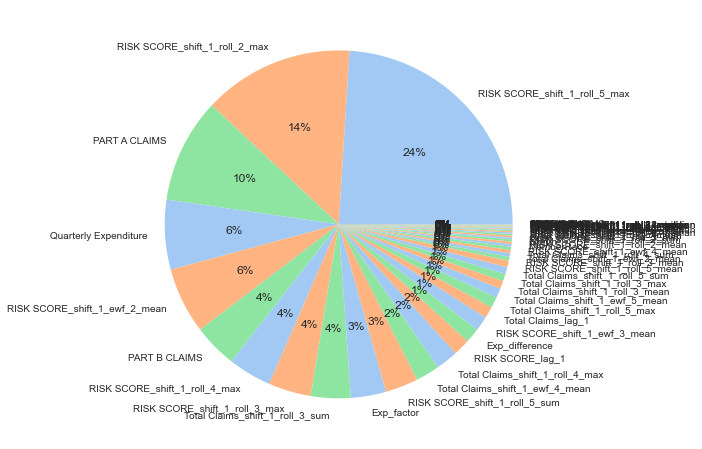

In [47]:
fe_imp_score = LGBM_feature_importance(X_train.columns, LGBM_model)

In [48]:
fe_imp_score

[(338441.4680454731, 'RISK SCORE_shift_1_roll_5_max'),
 (197396.74333643913, 'RISK SCORE_shift_1_roll_2_max'),
 (136824.73238182068, 'PART A CLAIMS'),
 (91234.41257667542, 'Quarterly Expenditure'),
 (86628.99861335754, 'RISK SCORE_shift_1_ewf_2_mean'),
 (57608.8338868618, 'PART B CLAIMS'),
 (56644.80203819275, 'RISK SCORE_shift_1_roll_4_max'),
 (56062.07960963249, 'RISK SCORE_shift_1_roll_3_max'),
 (52012.78447532654, 'Total Claims_shift_1_roll_3_sum'),
 (46153.919286727905, 'Exp_factor'),
 (43029.143756866455, 'RISK SCORE_shift_1_roll_5_sum'),
 (31580.918701171875, 'Total Claims_shift_1_ewf_4_mean'),
 (28861.64725112915, 'Total Claims_shift_1_roll_4_max'),
 (21847.74491238594, 'RISK SCORE_lag_1'),
 (19294.245012283325, 'Exp_difference'),
 (19272.98006248474, 'RISK SCORE_shift_1_ewf_3_mean'),
 (15085.94479560852, 'Total Claims_lag_1'),
 (14111.330724716187, 'Total Claims_shift_1_roll_5_max'),
 (12450.44702911377, 'Total Claims_shift_1_ewf_5_mean'),
 (10464.108909606934, 'Total Claims_s

## 3. Prediction

In [49]:
def concat_df_for_prediction(df, future_df, Year, Month, features):
    
    """
    Concat test set to the train set
    """
    
    future_df_temp = future_df[future_df['Month']==Month]
    future_df_predict = future_df_temp.copy()
    memberID_future = future_df_temp['MemberID'].unique()
    
    for col in features:
        future_df_predict[col] = np.nan
        
    df_for_predict = df[df['MemberID'].isin(memberID_future)]
    df_for_predict = pd.concat((df_for_predict, future_df_predict))
    df_for_predict_final = df_for_predict.groupby(['MemberID','Year','Month'], as_index=False)['Exp_factor'].sum()
    
    for col in features:
        temp = df_for_predict.groupby(['MemberID','Year','Month'], as_index=False)[col].sum()
        temp.loc[(temp['Year']==Year)&(temp['Month']==Month), col] = np.nan
        df_for_predict_final[col] = temp[col]
        
    return df_for_predict_final

In [50]:
def generating_feature_df(df, columns_shift=None):
    
    """
    Generate time series features for the dataset
    """
    
    temp = df.copy()
    temp = shift_additional_feature(temp, columns_shift)
    temp = create_tsf(temp, 'RISK SCORE')
    temp = create_tsf(temp, 'Total Claims')
    
    return temp

In [51]:
def predicting(final_df_test, feature_list, Year, Month, model, MemberID=None):
    
    """
    Predict the result for the test time
    """
        
    if MemberID == None:
        X_predict = final_df_test[(final_df_test['Year']==Year)&(final_df_test['Month']==Month)][feature_list]    
        y_predict = model.predict(X_predict) 
        y_proba_predict = model.predict_proba(X_predict)
    else:
        X_predict = final_df_test[(final_df_test['Year']==Year)&(final_df_test['Month']==Month)&(final_df_test['MemberID']==MemberID)][feature_list]
        X_predict.head()
        y_predict = model.predict(X_predict) 
        y_proba_predict = model.predict_proba(X_predict)
    


**LGBM Model Prediction**

12/2019 prediction

In [53]:
columns = df_for_train.drop(['MemberID', 'Year', 'Month'], axis=1).columns
df_for_prediction_2019_12 = concat_df_for_prediction(df_for_train, df_for_test1, Year=2019, Month=12, features=columns)
final_df_test_2019_12 = generating_feature_df(df_for_prediction_2019_12, columns_shift=additional_features)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.43s/it]


In [54]:
High_cost_2019_12_predict, proba_predict = predicting(final_df_test_2019_12, feature_list=X_train.columns,
                                                      Year=2019, Month=12, model=LGBM_model)

In [55]:
df_for_test1['High_cost_prediction'] = High_cost_2019_12_predict

In [56]:
df_for_test1['Not_high_cost_prediction_proba'] = proba_predict[:,0]
df_for_test1['High_cost_prediction_proba'] = proba_predict[:,1]

In [57]:
df_for_test2 = df_for_test1[['MemberID', 'Year', 'Month', 'High_cost_prediction', 'Not_high_cost_prediction_proba', 'High_cost_prediction_proba']]

In [58]:
Counter(High_cost_2019_12_predict)

Counter({0: 4843, 1: 371})

In [59]:
df_for_test2[df_for_test2['High_cost_prediction']==1]

,MemberID,Year,Month,High_cost_prediction,Not_high_cost_prediction_proba,High_cost_prediction_proba
7,1A65QP0JV61,2019,12,1,0.478,0.522
15,1AF4RD2MU50,2019,12,1,0.462,0.538
63,1CU2JT5CC25,2019,12,1,0.457,0.543
70,1D22VX8UX00,2019,12,1,0.447,0.553
72,1D26H29DX89,2019,12,1,0.437,0.563
...,...,...,...,...,...,...
5096,9VC0VM1JT44,2019,12,1,0.451,0.549
5133,9WG2K50TG00,2019,12,1,0.456,0.544
5143,9WV2UG4VY14,2019,12,1,0.487,0.513
5185,9Y37XH6PP53,2019,12,1,0.468,0.532


In [60]:
df_for_test2['High_cost_prediction_proba'].describe()

count   5214.000
mean       0.294
std        0.120
min        0.129
25%        0.190
50%        0.269
75%        0.386
max        0.593
Name: High_cost_prediction_proba, dtype: float64

In [61]:
df_for_test2.to_csv('High cost member prediction result-update.csv')